# Stacking

Julian Domingo - jad5348

In [14]:
# Data analysis 
import pandas as pd
import numpy as np

# Modeling stuff
import xgboost as xgb
from xgboost import XGBClassifier
from mlens.ensemble import SuperLearner
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier,
                              ExtraTreesClassifier,
                              BaggingClassifier)
from sklearn.model_selection import GridSearchCV, cross_val_score

# Computation / numerical
from scipy.stats import uniform, randint, hmean
from sklearn.metrics import roc_auc_score
from mlens.preprocessing import Subset
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
import matplotlib.pyplot as plt

# For reproducibility
seed = 42
np.random.seed(seed)

# Constants
n_splits = 5

In [2]:
test_ids = pd.read_csv("./data/raw/test.csv")[["id"]]
y_train = pd.read_csv("./data/raw/train.csv")["Y"].ravel()

#### Helper Functions

In [3]:
def save_preds(preds, preds_filename):
    submission = pd.DataFrame({"id": test_ids.id, "Y": preds})
    submission.to_csv("./submissions/stacking_{}.csv".format(preds_filename), index=False, columns=["id", "Y"])
    
    
def get_data(filename):
    train = pd.read_csv("./data/refined/train/train_{}.csv".format(filename))
    test = pd.read_csv("./data/refined/test/test_{}.csv".format(filename))
    
    x_train = train.drop(["Y"], axis = 1)
    y_train = train["Y"]
    
    return train, test, x_train, y_train


def get_cross_val_score(model, x_train, y_train, n_folds, run_parallel=True):
    if run_parallel:
        cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = "roc_auc", n_jobs = -1)
    else:
        cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = "roc_auc")

    print("Cross validation score: {} +/- {}\nRaw scores: {}".format(str(np.mean(cv)), str(np.std(cv)), str(cv)))
    return cv

In [4]:
train_raw, test_raw, x_train_raw, y_train_raw = get_data("raw")
train_base, test_base, x_train_base, y_train_base = get_data("base")
train_log, test_log, x_train_log, y_train_log = get_data("log")
train_poly, test_poly, x_train_poly, y_train_poly = get_data("poly")
train_scaled, test_scaled, x_train_scaled, y_train_scaled = get_data("scaled")

#### Stacking Class

Stacking works well for small to medium-sized data sets.

In [12]:
class Stacker(object):
    def __init__(self, base_learners, meta_learners, y_train, test_ids):
        self.base_learners = base_learners
        self.meta_learners = meta_learners
        self.y_train = y_train
        self.test_ids = test_ids
    
    
    def get_indiv_meta_preds(self, meta):
        """ Retrieves the predictions of the model 'meta'. """
        if self.meta_features_train is None or self.meta_features_test is None:
            raise ValueError("Invoke 'get_meta_features' before predicting.")
            
        meta.fit(self.meta_features_train, self.y_train)
        meta_preds = meta.predict_proba(self.meta_features_test)[:,1]
        return meta_preds
        
        
    def get_meta_features(self):
        """ Retrieves all meta features for the train & test data from the base learners specified. """
        self.meta_features_train = np.zeros((len(self.y_train), len(self.base_learners)))
        self.meta_features_test = np.zeros((len(self.test_ids), len(self.base_learners)))
        
        for i, base in enumerate(self.base_learners):
            print ("Gathering meta feature from '{}'...".format(base))
            self.meta_features_train[:, i] = pd.read_csv("./meta_features/train/train_{}.csv".format(base), \
                                                         index_col=0).as_matrix().ravel()
            self.meta_features_test[:, i] = pd.read_csv("./meta_features/test/test_{}.csv".format(base), \
                                                        index_col=0).as_matrix().ravel()
            
        return self.meta_features_train.copy(), self.meta_features_test.copy()
    
    
    def fit_meta_learners_and_predict(self):
        """ Generates predictions using all meta features generated from the base learners for each meta learner. """
        if self.meta_features_train is None or self.meta_features_test is None:
            raise ValueError("get_meta_features() should be called before generate_out_of_folds_preds.")
        
        self.meta_learner_preds = np.zeros((len(self.test_ids), len(self.meta_learners)))
        
        for i, meta in enumerate(self.meta_learners):
            meta.fit(self.meta_features_train, self.y_train)
            self.meta_learner_preds[:, i] =  meta.predict_proba(self.meta_features_test)[:,1]
            
    
    def get_df_meta_learner_preds(self):
        if self.meta_learner_preds is None:
            raise ValueError("No predictions were found. Invoke 'fit_meta_learners_and_predict' first.")
        
        if self.base_learners is None:
            raise ValueError("No base learners were specified. Construct an instance with base learners.")
        
        return pd.DataFrame(self.meta_learner_preds, columns=self.base_learners)
    
    
    def get_final_preds(self, mean="average"):
        if mean == "average":
            return np.mean(self.meta_learner_preds, axis=1)
        elif mean == "harmonic":
            return hmean(self.meta_learner_preds, axis=1)

## Meta Learner(s) Parameter Tuning & Predictions

### Ensemble 1
**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Raw
    * XGB Base
    * XGB Poly
    * LR Log
    * Ada Base
   
**Meta Learners: **
    * RF

In [31]:
base_learners_v1 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "logistic_regression_log",
    "adaboost_base"
]

rf_meta_v1 = RandomForestClassifier(n_jobs=-1)

meta_learners_v1 = [rf_meta_v1]

In [32]:
stacker_v1 = Stacker(base_learners_v1, meta_learners_v1, y_train, test_ids)
meta_features_train_v1, meta_features_test_v1 = stacker_v1.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...


In [11]:
# Warning: this block takes a long time to execute.
rf_meta_v1_param_grid = {
    "max_features": range(5, 7 + 1),
    "max_depth": range(5, 10 + 1),
    "n_estimators": range(300, 1000 + 1, 100) 
}

gs_rf_v1 = GridSearchCV(estimator=rf_meta_v1, param_grid=rf_meta_v1_param_grid, cv=n_splits, scoring="roc_auc", n_jobs=-1)
gs_rf_v1.fit(meta_features_train_v1, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [5, 6, 7], 'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [10]:
print gs_rf_v1.best_params_
print gs_rf_v1.best_score_

{'max_features': 6, 'n_estimators': 300, 'max_depth': 6}
0.772539082175


In [33]:
print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=6, max_features=6), meta_features_train_v1, y_train, n_folds=5)

Cross validation score: 0.771359868469 +/- 0.00723717612684
Raw scores: [ 0.76715711  0.77956341  0.75947714  0.77377431  0.77682737]
[ 0.76715711  0.77956341  0.75947714  0.77377431  0.77682737]


In [19]:
# Get predictions w/ tuned params
meta_preds_v1 = stacker_v1.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_features=6, max_depth=6))
print meta_preds_v1

[ 0.97136003  0.67447269  0.94252603 ...,  0.88289829  0.98178302
  0.96819782]


In [25]:
# Get predictions w/o tuned params
meta_preds_v1_untuned = stacker_v1.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1))
print meta_preds_v1_untuned

[ 1.   0.7  0.9 ...,  1.   1.   1. ]


As seen by the predictions without tuned parameters, tuning of the meta model makes a tremendous difference on the prediction set obtained.

### Ensemble 2
**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Raw
    * XGB Base
    * XGB Poly
    * LR Log
    * Ada Base
    * KNN_{2, 4, 8, 16, 32, 64, 128, 256, 512, 1024}
   
**Meta Learners: **
    * RF

In [24]:
base_learners_v2 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "logistic_regression_log",
    "adaboost_base",
    "knn_2",
    "knn_4",
    "knn_8",
    "knn_16",
    "knn_32",
    "knn_64",
    "knn_128",
    "knn_256",
    "knn_512",
    "knn_1024"
]

rf_meta_v2 = RandomForestClassifier(n_jobs=-1)
meta_learners_v2 = [rf_meta_v2]

stacker_v2 = Stacker(base_learners_v2, meta_learners_v2, y_train, test_ids)
meta_features_train_v2, meta_features_test_v2 = stacker_v2.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'knn_2'...
Gathering meta feature from 'knn_4'...
Gathering meta feature from 'knn_8'...
Gathering meta feature from 'knn_16'...
Gathering meta feature from 'knn_32'...
Gathering meta feature from 'knn_64'...
Gathering meta feature from 'knn_128'...
Gathering meta feature from 'knn_256'...
Gathering meta feature from 'knn_512'...
Gathering meta feature from 'knn_1024'...


In [29]:
# Warning: this block takes a long time to execute.
rf_meta_v2_param_grid = {
    "max_features": range(5, 7 + 1),
    "max_depth": range(5, 10 + 1),
    "n_estimators": range(300, 1000 + 1, 100) 
}

gs_rf_v2 = GridSearchCV(estimator=rf_meta_v2, param_grid=rf_meta_v2_param_grid, cv=n_splits, scoring="roc_auc", n_jobs=-1)
gs_rf_v2.fit(meta_features_train_v2, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [5, 6, 7], 'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [30]:
print gs_rf_v2.best_params_
print gs_rf_v2.best_score_

{'max_features': 5, 'n_estimators': 300, 'max_depth': 9}
0.773074767924


In [30]:
print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=9, max_features=5), meta_features_train_v2, y_train, n_folds=5)

Cross validation score: 0.769897637451 +/- 0.00448583181217
Raw scores: [ 0.76837689  0.77614972  0.77087385  0.76246286  0.77162487]
[ 0.76837689  0.77614972  0.77087385  0.76246286  0.77162487]


In [31]:
# Get predictions w/ tuned params
meta_preds_v2_tuned = stacker_v2.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=9, max_features=5))
print meta_preds_v2_tuned

[ 0.97460188  0.66699757  0.95640802 ...,  0.91079086  0.98644606
  0.97122791]


In [33]:
save_preds(meta_preds_v2_tuned, "_".join(base_learners_v2))

### Ensemble 3
**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Raw
    * XGB Base
    * XGB Poly
    * LR Log
    * Ada Base
    * Bagged XGB (50 runs)
    * Extra Trees Base
    
**Meta Learners: **
    * RF
    * XGB
    
**Final Predictions**: harmonic mean of meta learner predictions

In [20]:
base_learners_v3 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_base",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base"
]

rf_meta_v3 = RandomForestClassifier(n_jobs=-1, random_state=seed)
meta_learners_v3 = [rf_meta_v3]

stacker_v3 = Stacker(base_learners_v3, meta_learners_v3, y_train, test_ids)
meta_features_train_v3, meta_features_test_v3 = stacker_v3.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_bag'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'extra_trees_base'...


In [ ]:
# Warning: this block takes a long time to execute.
rf_v3_param_grid = {
    "max_features": range(2, 10 + 1),
    "max_depth": range(2, 10 + 1),
    "n_estimators": range(300, 1000 + 1, 100) 
}

gs_rf_v3 = GridSearchCV(estimator=rf_meta_v3, param_grid=rf_v3_param_grid, cv=n_splits, scoring="roc_auc", n_jobs=-1, verbose=5)
gs_rf_v3.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] max_features=2, n_estimators=300, max_depth=2 ...................
[CV] max_features=2, n_estimators=300, max_depth=2 ...................
[CV] max_features=2, n_estimators=300, max_depth=2 ...................
[CV] max_features=2, n_estimators=300, max_depth=2 ...................
[CV] max_features=2, n_estimators=300, max_depth=2 ...................
[CV] max_features=2, n_estimators=400, max_depth=2 ...................
[CV] max_features=2, n_estimators=400, max_depth=2 ...................
[CV] max_features=2, n_estimators=400, max_depth=2 ...................
[CV]  max_features=2, n_estimators=300, max_depth=2, score=0.770171, total=   3.9s
[CV]  max_features=2, n_estimators=300, max_depth=2, score=0.775249, total=   3.9s
[CV] max_features=2, n_estimators=400, max_depth=2 ...................
[CV] max_features=2, n_estimators=400, max_depth=2 ...................
[CV]  max_features=2, n_estimators=300, max_depth=2, score=0

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s


[CV]  max_features=2, n_estimators=400, max_depth=2, score=0.775677, total=   5.7s
[CV] max_features=2, n_estimators=500, max_depth=2 ...................
[CV]  max_features=2, n_estimators=400, max_depth=2, score=0.760451, total=   5.8s
[CV] max_features=2, n_estimators=500, max_depth=2 ...................
[CV]  max_features=2, n_estimators=400, max_depth=2, score=0.771273, total=   6.0s
[CV] max_features=2, n_estimators=600, max_depth=2 ...................
[CV]  max_features=2, n_estimators=400, max_depth=2, score=0.771247, total=   5.0s
[CV]  max_features=2, n_estimators=400, max_depth=2, score=0.776450, total=   5.1s
[CV] max_features=2, n_estimators=600, max_depth=2 ...................
[CV] max_features=2, n_estimators=600, max_depth=2 ...................
[CV]  max_features=2, n_estimators=500, max_depth=2, score=0.771290, total=   6.8s
[CV] max_features=2, n_estimators=600, max_depth=2 ...................
[CV]  max_features=2, n_estimators=500, max_depth=2, score=0.758607, total= 

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min


[CV]  max_features=3, n_estimators=600, max_depth=2, score=0.776124, total=  13.3s
[CV] max_features=3, n_estimators=700, max_depth=2 ...................
[CV]  max_features=3, n_estimators=600, max_depth=2, score=0.759977, total=  13.1s
[CV] max_features=3, n_estimators=800, max_depth=2 ...................
[CV]  max_features=3, n_estimators=600, max_depth=2, score=0.764451, total=  12.3s
[CV] max_features=3, n_estimators=800, max_depth=2 ...................
[CV]  max_features=3, n_estimators=600, max_depth=2, score=0.774741, total=  11.7s
[CV] max_features=3, n_estimators=800, max_depth=2 ...................
[CV]  max_features=3, n_estimators=700, max_depth=2, score=0.767588, total=  13.9s
[CV] max_features=3, n_estimators=800, max_depth=2 ...................
[CV]  max_features=3, n_estimators=700, max_depth=2, score=0.775820, total=  14.3s
[CV] max_features=3, n_estimators=800, max_depth=2 ...................
[CV]  max_features=3, n_estimators=700, max_depth=2, score=0.759403, total= 

[CV] max_features=4, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=4, n_estimators=900, max_depth=2, score=0.765999, total=  19.6s
[CV] max_features=4, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=4, n_estimators=900, max_depth=2, score=0.765222, total=  19.5s
[CV] max_features=4, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=4, n_estimators=900, max_depth=2, score=0.753700, total=  19.3s
[CV] max_features=5, n_estimators=300, max_depth=2 ...................
[CV]  max_features=4, n_estimators=900, max_depth=2, score=0.769554, total=  18.4s
[CV] max_features=5, n_estimators=300, max_depth=2 ...................
[CV]  max_features=4, n_estimators=900, max_depth=2, score=0.773399, total=  18.6s
[CV] max_features=5, n_estimators=300, max_depth=2 ...................
[CV]  max_features=5, n_estimators=300, max_depth=2, score=0.758731, total=   7.1s
[CV] max_features=5, n_estimators=300, max_depth=2 ...................
[CV] 

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.9min


[CV]  max_features=5, n_estimators=800, max_depth=2, score=0.764565, total=  19.3s
[CV] max_features=5, n_estimators=900, max_depth=2 ...................
[CV]  max_features=5, n_estimators=800, max_depth=2, score=0.752813, total=  18.3s
[CV] max_features=5, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=5, n_estimators=800, max_depth=2, score=0.767864, total=  17.2s
[CV] max_features=5, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=5, n_estimators=800, max_depth=2, score=0.778568, total=  17.0s
[CV] max_features=5, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=5, n_estimators=900, max_depth=2, score=0.765131, total=  20.9s
[CV] max_features=5, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=5, n_estimators=900, max_depth=2, score=0.764225, total=  21.7s
[CV] max_features=5, n_estimators=1000, max_depth=2 ..................
[CV]  max_features=5, n_estimators=900, max_depth=2, score=0.752698, total= 

[CV] max_features=7, n_estimators=400, max_depth=2 ...................
[CV]  max_features=7, n_estimators=300, max_depth=2, score=0.770534, total=  10.3s
[CV] max_features=7, n_estimators=400, max_depth=2 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=2, score=0.754404, total=  27.7s
[CV] max_features=7, n_estimators=400, max_depth=2 ...................
[CV]  max_features=7, n_estimators=300, max_depth=2, score=0.768028, total=   9.7s
[CV] max_features=7, n_estimators=500, max_depth=2 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=2, score=0.768134, total=  27.6s
[CV] max_features=7, n_estimators=500, max_depth=2 ...................
[CV]  max_features=7, n_estimators=400, max_depth=2, score=0.754647, total=  11.0s
[CV] max_features=7, n_estimators=500, max_depth=2 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=2, score=0.775553, total=  27.3s
[CV] max_features=7, n_estimators=500, max_depth=2 ...................
[C

[CV]  max_features=8, n_estimators=500, max_depth=2, score=0.763819, total=  15.2s
[CV] max_features=8, n_estimators=700, max_depth=2 ...................
[CV]  max_features=8, n_estimators=500, max_depth=2, score=0.764329, total=  15.5s
[CV] max_features=8, n_estimators=700, max_depth=2 ...................
[CV]  max_features=8, n_estimators=600, max_depth=2, score=0.754400, total=  19.0s
[CV] max_features=8, n_estimators=700, max_depth=2 ...................
[CV]  max_features=8, n_estimators=600, max_depth=2, score=0.767685, total=  19.6s
[CV] max_features=8, n_estimators=700, max_depth=2 ...................
[CV]  max_features=8, n_estimators=600, max_depth=2, score=0.753081, total=  19.4s
[CV] max_features=8, n_estimators=800, max_depth=2 ...................
[CV]  max_features=8, n_estimators=600, max_depth=2, score=0.763488, total=  17.9s
[CV] max_features=8, n_estimators=800, max_depth=2 ...................
[CV]  max_features=8, n_estimators=600, max_depth=2, score=0.763205, total= 

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.7min


[CV]  max_features=8, n_estimators=900, max_depth=2, score=0.754496, total=  31.0s
[CV] max_features=9, n_estimators=300, max_depth=2 ...................
[CV]  max_features=8, n_estimators=900, max_depth=2, score=0.763381, total=  30.1s
[CV] max_features=9, n_estimators=300, max_depth=2 ...................
[CV]  max_features=8, n_estimators=900, max_depth=2, score=0.766275, total=  29.3s
[CV] max_features=9, n_estimators=300, max_depth=2 ...................
[CV]  max_features=9, n_estimators=300, max_depth=2, score=0.756003, total=  12.5s
[CV] max_features=9, n_estimators=300, max_depth=2 ...................
[CV]  max_features=9, n_estimators=300, max_depth=2, score=0.750723, total=  12.6s
[CV] max_features=9, n_estimators=300, max_depth=2 ...................
[CV]  max_features=8, n_estimators=1000, max_depth=2, score=0.756851, total=  34.2s
[CV] max_features=9, n_estimators=400, max_depth=2 ...................
[CV]  max_features=9, n_estimators=300, max_depth=2, score=0.746877, total=

[CV] max_features=10, n_estimators=500, max_depth=2 ..................
[CV]  max_features=10, n_estimators=400, max_depth=2, score=0.745458, total=  12.9s
[CV] max_features=10, n_estimators=500, max_depth=2 ..................
[CV]  max_features=10, n_estimators=400, max_depth=2, score=0.753947, total=  13.1s
[CV] max_features=10, n_estimators=600, max_depth=2 ..................
[CV]  max_features=10, n_estimators=400, max_depth=2, score=0.764458, total=  12.6s
[CV] max_features=10, n_estimators=600, max_depth=2 ..................
[CV]  max_features=10, n_estimators=400, max_depth=2, score=0.766329, total=  12.3s
[CV] max_features=10, n_estimators=600, max_depth=2 ..................
[CV]  max_features=10, n_estimators=500, max_depth=2, score=0.757185, total=  16.3s
[CV] max_features=10, n_estimators=600, max_depth=2 ..................
[CV]  max_features=10, n_estimators=500, max_depth=2, score=0.745377, total=  16.5s
[CV] max_features=10, n_estimators=600, max_depth=2 ..................

[CV] max_features=2, n_estimators=800, max_depth=3 ...................
[CV]  max_features=2, n_estimators=600, max_depth=3, score=0.778275, total=  11.3s
[CV] max_features=2, n_estimators=800, max_depth=3 ...................
[CV]  max_features=2, n_estimators=700, max_depth=3, score=0.776947, total=  12.7s
[CV] max_features=2, n_estimators=800, max_depth=3 ...................
[CV]  max_features=2, n_estimators=700, max_depth=3, score=0.780900, total=  12.4s
[CV] max_features=2, n_estimators=800, max_depth=3 ...................
[CV]  max_features=2, n_estimators=700, max_depth=3, score=0.761279, total=  12.6s
[CV] max_features=2, n_estimators=900, max_depth=3 ...................
[CV]  max_features=2, n_estimators=700, max_depth=3, score=0.770592, total=  12.2s
[CV] max_features=2, n_estimators=900, max_depth=3 ...................
[CV]  max_features=2, n_estimators=700, max_depth=3, score=0.778408, total=  12.4s
[CV] max_features=2, n_estimators=900, max_depth=3 ...................
[CV] 

[CV]  max_features=3, n_estimators=900, max_depth=3, score=0.760650, total=  19.3s
[CV] max_features=4, n_estimators=300, max_depth=3 ...................
[CV]  max_features=3, n_estimators=900, max_depth=3, score=0.772690, total=  19.4s
[CV] max_features=4, n_estimators=300, max_depth=3 ...................


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.6min


[CV]  max_features=3, n_estimators=900, max_depth=3, score=0.779191, total=  19.1s
[CV] max_features=4, n_estimators=300, max_depth=3 ...................
[CV]  max_features=4, n_estimators=300, max_depth=3, score=0.776795, total=   7.7s
[CV] max_features=4, n_estimators=300, max_depth=3 ...................
[CV]  max_features=3, n_estimators=1000, max_depth=3, score=0.776558, total=  21.8s
[CV] max_features=4, n_estimators=300, max_depth=3 ...................
[CV]  max_features=4, n_estimators=300, max_depth=3, score=0.781359, total=   9.9s
[CV] max_features=4, n_estimators=400, max_depth=3 ...................
[CV]  max_features=3, n_estimators=1000, max_depth=3, score=0.782237, total=  23.6s
[CV] max_features=4, n_estimators=400, max_depth=3 ...................
[CV]  max_features=4, n_estimators=300, max_depth=3, score=0.760505, total=  10.0s
[CV] max_features=4, n_estimators=400, max_depth=3 ...................
[CV]  max_features=3, n_estimators=1000, max_depth=3, score=0.760518, tota

[CV] max_features=5, n_estimators=600, max_depth=3 ...................
[CV]  max_features=5, n_estimators=400, max_depth=3, score=0.758375, total=  11.4s
[CV] max_features=5, n_estimators=600, max_depth=3 ...................
[CV]  max_features=5, n_estimators=400, max_depth=3, score=0.779098, total=  10.9s
[CV] max_features=5, n_estimators=600, max_depth=3 ...................
[CV]  max_features=5, n_estimators=500, max_depth=3, score=0.776654, total=  13.3s
[CV] max_features=5, n_estimators=600, max_depth=3 ...................
[CV]  max_features=5, n_estimators=500, max_depth=3, score=0.758000, total=  13.9s
[CV] max_features=5, n_estimators=600, max_depth=3 ...................
[CV]  max_features=5, n_estimators=500, max_depth=3, score=0.783336, total=  14.1s
[CV] max_features=5, n_estimators=700, max_depth=3 ...................
[CV]  max_features=5, n_estimators=500, max_depth=3, score=0.772305, total=  14.0s
[CV] max_features=5, n_estimators=700, max_depth=3 ...................
[CV] 

[CV]  max_features=6, n_estimators=700, max_depth=3, score=0.783235, total=  22.8s
[CV] max_features=6, n_estimators=800, max_depth=3 ...................
[CV]  max_features=6, n_estimators=700, max_depth=3, score=0.757098, total=  23.1s
[CV] max_features=6, n_estimators=900, max_depth=3 ...................
[CV]  max_features=6, n_estimators=700, max_depth=3, score=0.771625, total=  23.0s
[CV] max_features=6, n_estimators=900, max_depth=3 ...................
[CV]  max_features=6, n_estimators=700, max_depth=3, score=0.777174, total=  23.0s
[CV] max_features=6, n_estimators=900, max_depth=3 ...................
[CV]  max_features=6, n_estimators=800, max_depth=3, score=0.776250, total=  26.0s
[CV] max_features=6, n_estimators=900, max_depth=3 ...................
[CV]  max_features=6, n_estimators=800, max_depth=3, score=0.782612, total=  25.7s
[CV] max_features=6, n_estimators=900, max_depth=3 ...................
[CV]  max_features=6, n_estimators=800, max_depth=3, score=0.757695, total= 

[CV] max_features=8, n_estimators=300, max_depth=3 ...................
[CV]  max_features=7, n_estimators=900, max_depth=3, score=0.778480, total=  35.9s
[CV] max_features=8, n_estimators=300, max_depth=3 ...................
[CV]  max_features=7, n_estimators=1000, max_depth=3, score=0.776730, total=  40.3s
[CV] max_features=8, n_estimators=300, max_depth=3 ...................
[CV]  max_features=8, n_estimators=300, max_depth=3, score=0.783284, total=  15.3s
[CV] max_features=8, n_estimators=400, max_depth=3 ...................
[CV]  max_features=7, n_estimators=1000, max_depth=3, score=0.782734, total=  42.0s
[CV] max_features=8, n_estimators=400, max_depth=3 ...................
[CV]  max_features=8, n_estimators=300, max_depth=3, score=0.760163, total=  15.4s
[CV] max_features=8, n_estimators=400, max_depth=3 ...................
[CV]  max_features=8, n_estimators=300, max_depth=3, score=0.771547, total=  15.2s
[CV] max_features=8, n_estimators=400, max_depth=3 ...................
[CV

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 27.6min


[CV]  max_features=8, n_estimators=900, max_depth=3, score=0.759651, total=  36.0s
[CV] max_features=9, n_estimators=300, max_depth=3 ...................
[CV]  max_features=8, n_estimators=900, max_depth=3, score=0.771458, total=  36.2s
[CV] max_features=9, n_estimators=300, max_depth=3 ...................
[CV]  max_features=9, n_estimators=300, max_depth=3, score=0.775442, total=  14.4s
[CV] max_features=9, n_estimators=300, max_depth=3 ...................
[CV]  max_features=8, n_estimators=900, max_depth=3, score=0.778412, total=  37.9s
[CV] max_features=9, n_estimators=300, max_depth=3 ...................
[CV]  max_features=9, n_estimators=300, max_depth=3, score=0.782634, total=  15.9s
[CV] max_features=9, n_estimators=300, max_depth=3 ...................
[CV]  max_features=8, n_estimators=1000, max_depth=3, score=0.777348, total=  42.4s
[CV] max_features=9, n_estimators=400, max_depth=3 ...................
[CV]  max_features=8, n_estimators=1000, max_depth=3, score=0.782562, total

[CV] max_features=10, n_estimators=500, max_depth=3 ..................
[CV]  max_features=10, n_estimators=400, max_depth=3, score=0.784960, total=  18.5s
[CV] max_features=10, n_estimators=500, max_depth=3 ..................
[CV]  max_features=10, n_estimators=400, max_depth=3, score=0.757027, total=  18.2s
[CV]  max_features=10, n_estimators=400, max_depth=3, score=0.770613, total=  18.0s
[CV] max_features=10, n_estimators=600, max_depth=3 ..................
[CV] max_features=10, n_estimators=600, max_depth=3 ..................
[CV]  max_features=10, n_estimators=400, max_depth=3, score=0.776819, total=  17.4s
[CV] max_features=10, n_estimators=600, max_depth=3 ..................
[CV]  max_features=10, n_estimators=500, max_depth=3, score=0.775905, total=  22.5s
[CV] max_features=10, n_estimators=600, max_depth=3 ..................
[CV]  max_features=10, n_estimators=500, max_depth=3, score=0.784997, total=  23.0s
[CV] max_features=10, n_estimators=600, max_depth=3 ..................

[CV] max_features=2, n_estimators=800, max_depth=4 ...................
[CV]  max_features=2, n_estimators=600, max_depth=4, score=0.779828, total=  11.6s
[CV] max_features=2, n_estimators=800, max_depth=4 ...................
[CV]  max_features=2, n_estimators=700, max_depth=4, score=0.776555, total=  14.3s
[CV] max_features=2, n_estimators=800, max_depth=4 ...................
[CV]  max_features=2, n_estimators=700, max_depth=4, score=0.782960, total=  14.4s
[CV] max_features=2, n_estimators=800, max_depth=4 ...................
[CV]  max_features=2, n_estimators=700, max_depth=4, score=0.762338, total=  14.2s
[CV] max_features=2, n_estimators=900, max_depth=4 ...................
[CV]  max_features=2, n_estimators=700, max_depth=4, score=0.772414, total=  13.9s
[CV] max_features=2, n_estimators=900, max_depth=4 ...................
[CV]  max_features=2, n_estimators=700, max_depth=4, score=0.779869, total=  13.1s
[CV] max_features=2, n_estimators=900, max_depth=4 ...................
[CV] 

[CV]  max_features=3, n_estimators=900, max_depth=4, score=0.760965, total=  23.0s
[CV] max_features=4, n_estimators=300, max_depth=4 ...................
[CV]  max_features=3, n_estimators=900, max_depth=4, score=0.772515, total=  23.1s
[CV] max_features=4, n_estimators=300, max_depth=4 ...................
[CV]  max_features=3, n_estimators=900, max_depth=4, score=0.779968, total=  23.1s
[CV] max_features=4, n_estimators=300, max_depth=4 ...................
[CV]  max_features=4, n_estimators=300, max_depth=4, score=0.776926, total=   8.7s
[CV] max_features=4, n_estimators=300, max_depth=4 ...................
[CV]  max_features=4, n_estimators=300, max_depth=4, score=0.784228, total=  10.4s
[CV] max_features=4, n_estimators=300, max_depth=4 ...................
[CV]  max_features=3, n_estimators=1000, max_depth=4, score=0.776709, total=  26.5s
[CV] max_features=4, n_estimators=400, max_depth=4 ...................
[CV]  max_features=4, n_estimators=300, max_depth=4, score=0.760168, total=

[CV] max_features=5, n_estimators=500, max_depth=4 ...................
[CV]  max_features=5, n_estimators=400, max_depth=4, score=0.784047, total=  13.6s
[CV] max_features=5, n_estimators=500, max_depth=4 ...................
[CV]  max_features=5, n_estimators=400, max_depth=4, score=0.760429, total=  13.7s
[CV]  max_features=5, n_estimators=400, max_depth=4, score=0.772777, total=  13.3s
[CV] max_features=5, n_estimators=600, max_depth=4 ...................
[CV] max_features=5, n_estimators=600, max_depth=4 ...................
[CV]  max_features=5, n_estimators=400, max_depth=4, score=0.778941, total=  12.8s
[CV] max_features=5, n_estimators=600, max_depth=4 ...................
[CV]  max_features=5, n_estimators=500, max_depth=4, score=0.777884, total=  15.6s
[CV] max_features=5, n_estimators=600, max_depth=4 ...................
[CV]  max_features=5, n_estimators=500, max_depth=4, score=0.784887, total=  16.1s
[CV] max_features=5, n_estimators=600, max_depth=4 ...................
[CV] 

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 39.7min


[CV]  max_features=5, n_estimators=800, max_depth=4, score=0.784258, total=  27.9s
[CV] max_features=5, n_estimators=900, max_depth=4 ...................
[CV]  max_features=5, n_estimators=800, max_depth=4, score=0.760710, total=  27.8s
[CV] max_features=5, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=5, n_estimators=800, max_depth=4, score=0.772394, total=  27.4s
[CV] max_features=5, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=5, n_estimators=800, max_depth=4, score=0.779174, total=  27.7s
[CV] max_features=5, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=5, n_estimators=900, max_depth=4, score=0.778022, total=  31.0s
[CV] max_features=5, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=5, n_estimators=900, max_depth=4, score=0.760645, total=  30.8s
[CV] max_features=5, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=5, n_estimators=900, max_depth=4, score=0.784352, total= 

[CV] max_features=7, n_estimators=400, max_depth=4 ...................
[CV]  max_features=7, n_estimators=300, max_depth=4, score=0.771538, total=  15.6s
[CV] max_features=7, n_estimators=400, max_depth=4 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=4, score=0.759947, total=  42.2s
[CV] max_features=7, n_estimators=400, max_depth=4 ...................
[CV]  max_features=7, n_estimators=300, max_depth=4, score=0.778303, total=  12.9s
[CV] max_features=7, n_estimators=500, max_depth=4 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=4, score=0.772466, total=  42.4s
[CV] max_features=7, n_estimators=500, max_depth=4 ...................
[CV]  max_features=7, n_estimators=400, max_depth=4, score=0.777438, total=  17.1s
[CV] max_features=7, n_estimators=500, max_depth=4 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=4, score=0.779275, total=  42.2s
[CV] max_features=7, n_estimators=500, max_depth=4 ...................
[C

[CV]  max_features=8, n_estimators=500, max_depth=4, score=0.771018, total=  23.7s
[CV] max_features=8, n_estimators=700, max_depth=4 ...................
[CV]  max_features=8, n_estimators=500, max_depth=4, score=0.778474, total=  24.0s
[CV] max_features=8, n_estimators=700, max_depth=4 ...................
[CV]  max_features=8, n_estimators=600, max_depth=4, score=0.777789, total=  28.9s
[CV] max_features=8, n_estimators=700, max_depth=4 ...................
[CV]  max_features=8, n_estimators=600, max_depth=4, score=0.785932, total=  29.0s
[CV] max_features=8, n_estimators=700, max_depth=4 ...................
[CV]  max_features=8, n_estimators=600, max_depth=4, score=0.758525, total=  29.3s
[CV] max_features=8, n_estimators=800, max_depth=4 ...................
[CV]  max_features=8, n_estimators=600, max_depth=4, score=0.770635, total=  28.9s
[CV] max_features=8, n_estimators=800, max_depth=4 ...................
[CV]  max_features=8, n_estimators=600, max_depth=4, score=0.778393, total= 

[CV] max_features=9, n_estimators=900, max_depth=4 ...................
[CV]  max_features=9, n_estimators=800, max_depth=4, score=0.758052, total=  42.1s
[CV] max_features=9, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=9, n_estimators=800, max_depth=4, score=0.769522, total=  41.8s
[CV] max_features=9, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=9, n_estimators=800, max_depth=4, score=0.777492, total=  41.6s
[CV] max_features=9, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=9, n_estimators=900, max_depth=4, score=0.777946, total=  47.0s
[CV] max_features=9, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=9, n_estimators=900, max_depth=4, score=0.786033, total=  48.1s
[CV] max_features=9, n_estimators=1000, max_depth=4 ..................
[CV]  max_features=9, n_estimators=900, max_depth=4, score=0.757772, total=  48.0s
[CV] max_features=10, n_estimators=300, max_depth=4 ..................
[CV] 

[CV] max_features=2, n_estimators=400, max_depth=5 ...................
[CV]  max_features=2, n_estimators=300, max_depth=5, score=0.780185, total=  10.8s
[CV] max_features=2, n_estimators=400, max_depth=5 ...................
[CV]  max_features=2, n_estimators=400, max_depth=5, score=0.776607, total=  13.5s
[CV] max_features=2, n_estimators=400, max_depth=5 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=4, score=0.785623, total=  59.1s
[CV] max_features=2, n_estimators=500, max_depth=5 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=4, score=0.758430, total=  57.6s
[CV] max_features=2, n_estimators=500, max_depth=5 ...................
[CV]  max_features=2, n_estimators=400, max_depth=5, score=0.784034, total=  12.3s
[CV] max_features=2, n_estimators=500, max_depth=5 ...................
[CV]  max_features=2, n_estimators=400, max_depth=5, score=0.762527, total=  11.8s
[CV] max_features=2, n_estimators=500, max_depth=5 ...................
[

[CV]  max_features=3, n_estimators=500, max_depth=5, score=0.771566, total=  12.6s
[CV] max_features=3, n_estimators=700, max_depth=5 ...................
[CV]  max_features=3, n_estimators=500, max_depth=5, score=0.780363, total=  13.6s
[CV] max_features=3, n_estimators=700, max_depth=5 ...................
[CV]  max_features=3, n_estimators=600, max_depth=5, score=0.777357, total=  16.2s
[CV] max_features=3, n_estimators=700, max_depth=5 ...................


[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 57.0min


[CV]  max_features=3, n_estimators=600, max_depth=5, score=0.786816, total=  16.2s
[CV] max_features=3, n_estimators=700, max_depth=5 ...................
[CV]  max_features=3, n_estimators=600, max_depth=5, score=0.762328, total=  16.6s
[CV] max_features=3, n_estimators=800, max_depth=5 ...................
[CV]  max_features=3, n_estimators=600, max_depth=5, score=0.772042, total=  16.1s
[CV] max_features=3, n_estimators=800, max_depth=5 ...................
[CV]  max_features=3, n_estimators=600, max_depth=5, score=0.780572, total=  15.7s
[CV] max_features=3, n_estimators=800, max_depth=5 ...................
[CV]  max_features=3, n_estimators=700, max_depth=5, score=0.777026, total=  18.8s
[CV] max_features=3, n_estimators=800, max_depth=5 ...................
[CV]  max_features=3, n_estimators=700, max_depth=5, score=0.786352, total=  19.1s
[CV] max_features=3, n_estimators=800, max_depth=5 ...................
[CV]  max_features=3, n_estimators=700, max_depth=5, score=0.761833, total= 

[CV] max_features=4, n_estimators=1000, max_depth=5 ..................
[CV]  max_features=4, n_estimators=900, max_depth=5, score=0.776597, total=  29.9s
[CV] max_features=4, n_estimators=1000, max_depth=5 ..................
[CV]  max_features=4, n_estimators=900, max_depth=5, score=0.786595, total=  29.9s
[CV] max_features=4, n_estimators=1000, max_depth=5 ..................
[CV]  max_features=4, n_estimators=900, max_depth=5, score=0.760501, total=  30.1s
[CV] max_features=5, n_estimators=300, max_depth=5 ...................
[CV]  max_features=4, n_estimators=900, max_depth=5, score=0.773268, total=  30.3s
[CV] max_features=5, n_estimators=300, max_depth=5 ...................
[CV]  max_features=4, n_estimators=900, max_depth=5, score=0.780385, total=  31.0s
[CV] max_features=5, n_estimators=300, max_depth=5 ...................
[CV]  max_features=5, n_estimators=300, max_depth=5, score=0.777572, total=  11.4s
[CV] max_features=5, n_estimators=300, max_depth=5 ...................
[CV] 

[CV]  max_features=5, n_estimators=1000, max_depth=5, score=0.773064, total=  41.9s
[CV] max_features=6, n_estimators=500, max_depth=5 ...................
[CV]  max_features=6, n_estimators=400, max_depth=5, score=0.777130, total=  18.4s
[CV] max_features=6, n_estimators=500, max_depth=5 ...................
[CV]  max_features=5, n_estimators=1000, max_depth=5, score=0.780112, total=  44.6s
[CV] max_features=6, n_estimators=500, max_depth=5 ...................
[CV]  max_features=6, n_estimators=400, max_depth=5, score=0.787752, total=  18.0s
[CV] max_features=6, n_estimators=500, max_depth=5 ...................
[CV]  max_features=6, n_estimators=400, max_depth=5, score=0.758009, total=  17.5s
[CV] max_features=6, n_estimators=600, max_depth=5 ...................
[CV]  max_features=6, n_estimators=400, max_depth=5, score=0.772471, total=  17.7s
[CV] max_features=6, n_estimators=600, max_depth=5 ...................
[CV]  max_features=6, n_estimators=400, max_depth=5, score=0.778896, total

[CV] max_features=7, n_estimators=700, max_depth=5 ...................
[CV]  max_features=7, n_estimators=600, max_depth=5, score=0.758654, total=  30.7s
[CV] max_features=7, n_estimators=800, max_depth=5 ...................
[CV]  max_features=7, n_estimators=600, max_depth=5, score=0.770974, total=  30.4s
[CV] max_features=7, n_estimators=800, max_depth=5 ...................
[CV]  max_features=7, n_estimators=600, max_depth=5, score=0.778760, total=  28.8s
[CV] max_features=7, n_estimators=800, max_depth=5 ...................
[CV]  max_features=7, n_estimators=700, max_depth=5, score=0.778202, total=  35.2s
[CV] max_features=7, n_estimators=800, max_depth=5 ...................
[CV]  max_features=7, n_estimators=700, max_depth=5, score=0.786013, total=  35.3s
[CV] max_features=7, n_estimators=800, max_depth=5 ...................
[CV]  max_features=7, n_estimators=700, max_depth=5, score=0.758271, total=  35.3s
[CV] max_features=7, n_estimators=900, max_depth=5 ...................
[CV] 

[CV]  max_features=8, n_estimators=900, max_depth=5, score=0.777662, total=  50.7s
[CV] max_features=8, n_estimators=1000, max_depth=5 ..................
[CV]  max_features=8, n_estimators=900, max_depth=5, score=0.787250, total=  51.7s
[CV] max_features=8, n_estimators=1000, max_depth=5 ..................
[CV]  max_features=8, n_estimators=900, max_depth=5, score=0.758909, total=  51.6s
[CV] max_features=9, n_estimators=300, max_depth=5 ...................
[CV]  max_features=8, n_estimators=900, max_depth=5, score=0.771167, total=  52.4s
[CV] max_features=9, n_estimators=300, max_depth=5 ...................
[CV]  max_features=9, n_estimators=300, max_depth=5, score=0.776652, total=  20.2s
[CV] max_features=9, n_estimators=300, max_depth=5 ...................
[CV]  max_features=8, n_estimators=900, max_depth=5, score=0.778298, total=  53.2s
[CV] max_features=9, n_estimators=300, max_depth=5 ...................
[CV]  max_features=9, n_estimators=300, max_depth=5, score=0.786123, total= 

[CV] max_features=10, n_estimators=500, max_depth=5 ..................
[CV]  max_features=10, n_estimators=400, max_depth=5, score=0.777413, total=  27.5s
[CV] max_features=10, n_estimators=500, max_depth=5 ..................
[CV]  max_features=9, n_estimators=1000, max_depth=5, score=0.777804, total= 1.1min
[CV] max_features=10, n_estimators=500, max_depth=5 ..................
[CV]  max_features=10, n_estimators=400, max_depth=5, score=0.786016, total=  26.8s
[CV]  max_features=10, n_estimators=400, max_depth=5, score=0.757758, total=  26.7s
[CV] max_features=10, n_estimators=500, max_depth=5 ..................
[CV] max_features=10, n_estimators=600, max_depth=5 ..................
[CV]  max_features=10, n_estimators=400, max_depth=5, score=0.770303, total=  26.7s
[CV] max_features=10, n_estimators=600, max_depth=5 ..................
[CV]  max_features=10, n_estimators=400, max_depth=5, score=0.777399, total=  26.3s
[CV] max_features=10, n_estimators=600, max_depth=5 ..................

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 79.6min


[CV]  max_features=10, n_estimators=1000, max_depth=5, score=0.786792, total= 1.1min
[CV] max_features=2, n_estimators=500, max_depth=6 ...................
[CV]  max_features=2, n_estimators=400, max_depth=6, score=0.787157, total=  13.3s
[CV] max_features=2, n_estimators=500, max_depth=6 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=5, score=0.757920, total= 1.1min
[CV] max_features=2, n_estimators=500, max_depth=6 ...................
[CV]  max_features=2, n_estimators=400, max_depth=6, score=0.762343, total=  13.3s
[CV] max_features=2, n_estimators=500, max_depth=6 ...................
[CV]  max_features=2, n_estimators=400, max_depth=6, score=0.774102, total=  12.8s
[CV] max_features=2, n_estimators=500, max_depth=6 ...................
[CV]  max_features=2, n_estimators=400, max_depth=6, score=0.780651, total=  12.3s
[CV] max_features=2, n_estimators=600, max_depth=6 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=5, score=0.770529, t

[CV] max_features=3, n_estimators=700, max_depth=6 ...................
[CV]  max_features=3, n_estimators=600, max_depth=6, score=0.788408, total=  18.6s
[CV] max_features=3, n_estimators=700, max_depth=6 ...................
[CV]  max_features=3, n_estimators=600, max_depth=6, score=0.760891, total=  18.5s
[CV] max_features=3, n_estimators=800, max_depth=6 ...................
[CV]  max_features=3, n_estimators=600, max_depth=6, score=0.774374, total=  18.2s
[CV] max_features=3, n_estimators=800, max_depth=6 ...................
[CV]  max_features=3, n_estimators=600, max_depth=6, score=0.781093, total=  18.2s
[CV] max_features=3, n_estimators=800, max_depth=6 ...................
[CV]  max_features=3, n_estimators=700, max_depth=6, score=0.776189, total=  21.4s
[CV] max_features=3, n_estimators=800, max_depth=6 ...................
[CV]  max_features=3, n_estimators=700, max_depth=6, score=0.788321, total=  21.1s
[CV] max_features=3, n_estimators=800, max_depth=6 ...................
[CV] 

[CV]  max_features=4, n_estimators=800, max_depth=6, score=0.779339, total=  30.4s
[CV] max_features=4, n_estimators=1000, max_depth=6 ..................
[CV]  max_features=4, n_estimators=900, max_depth=6, score=0.777537, total=  34.3s
[CV] max_features=4, n_estimators=1000, max_depth=6 ..................
[CV]  max_features=4, n_estimators=900, max_depth=6, score=0.788437, total=  34.5s
[CV]  max_features=4, n_estimators=900, max_depth=6, score=0.758747, total=  34.4s
[CV] max_features=4, n_estimators=1000, max_depth=6 ..................
[CV] max_features=5, n_estimators=300, max_depth=6 ...................
[CV]  max_features=4, n_estimators=900, max_depth=6, score=0.772641, total=  34.2s
[CV] max_features=5, n_estimators=300, max_depth=6 ...................
[CV]  max_features=4, n_estimators=900, max_depth=6, score=0.779436, total=  36.2s
[CV] max_features=5, n_estimators=300, max_depth=6 ...................
[CV]  max_features=5, n_estimators=300, max_depth=6, score=0.775972, total= 

[CV] max_features=6, n_estimators=500, max_depth=6 ...................
[CV]  max_features=5, n_estimators=1000, max_depth=6, score=0.772596, total=  48.1s
[CV] max_features=6, n_estimators=500, max_depth=6 ...................
[CV]  max_features=6, n_estimators=400, max_depth=6, score=0.777468, total=  20.6s
[CV] max_features=6, n_estimators=500, max_depth=6 ...................
[CV]  max_features=5, n_estimators=1000, max_depth=6, score=0.779142, total=  49.7s
[CV] max_features=6, n_estimators=500, max_depth=6 ...................
[CV]  max_features=6, n_estimators=400, max_depth=6, score=0.789411, total=  20.0s
[CV] max_features=6, n_estimators=500, max_depth=6 ...................
[CV]  max_features=6, n_estimators=400, max_depth=6, score=0.760457, total=  19.6s
[CV] max_features=6, n_estimators=600, max_depth=6 ...................
[CV]  max_features=6, n_estimators=400, max_depth=6, score=0.772661, total=  19.4s
[CV] max_features=6, n_estimators=600, max_depth=6 ...................
[CV

[CV]  max_features=7, n_estimators=600, max_depth=6, score=0.789068, total=  35.6s
[CV] max_features=7, n_estimators=700, max_depth=6 ...................
[CV]  max_features=7, n_estimators=600, max_depth=6, score=0.759669, total=  35.7s
[CV] max_features=7, n_estimators=800, max_depth=6 ...................
[CV]  max_features=7, n_estimators=600, max_depth=6, score=0.772413, total=  34.9s
[CV] max_features=7, n_estimators=800, max_depth=6 ...................
[CV]  max_features=7, n_estimators=600, max_depth=6, score=0.779006, total=  34.5s
[CV] max_features=7, n_estimators=800, max_depth=6 ...................
[CV]  max_features=7, n_estimators=700, max_depth=6, score=0.776832, total=  40.8s
[CV] max_features=7, n_estimators=800, max_depth=6 ...................
[CV]  max_features=7, n_estimators=700, max_depth=6, score=0.788970, total=  41.3s
[CV] max_features=7, n_estimators=800, max_depth=6 ...................
[CV]  max_features=7, n_estimators=700, max_depth=6, score=0.759427, total= 

[CV] max_features=8, n_estimators=1000, max_depth=6 ..................
[CV]  max_features=8, n_estimators=900, max_depth=6, score=0.777757, total=  58.7s
[CV] max_features=8, n_estimators=1000, max_depth=6 ..................
[CV]  max_features=8, n_estimators=900, max_depth=6, score=0.788741, total=  59.1s
[CV] max_features=8, n_estimators=1000, max_depth=6 ..................
[CV]  max_features=8, n_estimators=900, max_depth=6, score=0.758208, total=  59.5s
[CV] max_features=9, n_estimators=300, max_depth=6 ...................
[CV]  max_features=8, n_estimators=900, max_depth=6, score=0.772297, total=  59.9s
[CV] max_features=9, n_estimators=300, max_depth=6 ...................
[CV]  max_features=8, n_estimators=900, max_depth=6, score=0.777959, total= 1.0min
[CV] max_features=9, n_estimators=300, max_depth=6 ...................
[CV]  max_features=9, n_estimators=300, max_depth=6, score=0.776632, total=  23.5s
[CV] max_features=9, n_estimators=300, max_depth=6 ...................
[CV] 

[CV]  max_features=9, n_estimators=1000, max_depth=6, score=0.771309, total= 1.3min
[CV] max_features=10, n_estimators=500, max_depth=6 ..................
[CV]  max_features=10, n_estimators=400, max_depth=6, score=0.775917, total=  32.2s
[CV] max_features=10, n_estimators=500, max_depth=6 ..................
[CV]  max_features=9, n_estimators=1000, max_depth=6, score=0.777074, total= 1.3min
[CV] max_features=10, n_estimators=500, max_depth=6 ..................
[CV]  max_features=10, n_estimators=400, max_depth=6, score=0.786973, total=  31.1s
[CV] max_features=10, n_estimators=500, max_depth=6 ..................
[CV]  max_features=10, n_estimators=400, max_depth=6, score=0.757712, total=  30.7s
[CV] max_features=10, n_estimators=600, max_depth=6 ..................
[CV]  max_features=10, n_estimators=400, max_depth=6, score=0.771889, total=  30.4s
[CV] max_features=10, n_estimators=600, max_depth=6 ..................
[CV]  max_features=10, n_estimators=400, max_depth=6, score=0.776040, 

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 105.4min


[CV]  max_features=10, n_estimators=700, max_depth=6, score=0.775961, total=  56.3s
[CV] max_features=10, n_estimators=900, max_depth=6 ..................
[CV]  max_features=10, n_estimators=800, max_depth=6, score=0.775887, total= 1.1min
[CV] max_features=10, n_estimators=900, max_depth=6 ..................
[CV]  max_features=10, n_estimators=800, max_depth=6, score=0.787924, total= 1.1min
[CV] max_features=10, n_estimators=900, max_depth=6 ..................
[CV]  max_features=10, n_estimators=800, max_depth=6, score=0.756944, total= 1.1min
[CV] max_features=10, n_estimators=1000, max_depth=6 .................
[CV]  max_features=10, n_estimators=800, max_depth=6, score=0.771399, total= 1.1min
[CV] max_features=10, n_estimators=1000, max_depth=6 .................
[CV]  max_features=10, n_estimators=800, max_depth=6, score=0.775971, total= 1.1min
[CV] max_features=10, n_estimators=1000, max_depth=6 .................
[CV]  max_features=10, n_estimators=900, max_depth=6, score=0.775999, 

[CV] max_features=3, n_estimators=400, max_depth=7 ...................
[CV]  max_features=3, n_estimators=300, max_depth=7, score=0.788592, total=  11.1s
[CV] max_features=3, n_estimators=400, max_depth=7 ...................
[CV]  max_features=2, n_estimators=1000, max_depth=7, score=0.759996, total=  28.7s
[CV] max_features=3, n_estimators=400, max_depth=7 ...................
[CV]  max_features=3, n_estimators=300, max_depth=7, score=0.760022, total=  11.0s
[CV] max_features=3, n_estimators=400, max_depth=7 ...................
[CV]  max_features=2, n_estimators=1000, max_depth=7, score=0.772370, total=  30.3s
[CV] max_features=3, n_estimators=400, max_depth=7 ...................
[CV]  max_features=3, n_estimators=300, max_depth=7, score=0.775935, total=  10.8s
[CV] max_features=3, n_estimators=500, max_depth=7 ...................
[CV]  max_features=3, n_estimators=300, max_depth=7, score=0.780193, total=  10.7s
[CV] max_features=3, n_estimators=500, max_depth=7 ...................
[CV

[CV]  max_features=4, n_estimators=500, max_depth=7, score=0.788829, total=  20.4s
[CV] max_features=4, n_estimators=600, max_depth=7 ...................
[CV]  max_features=4, n_estimators=500, max_depth=7, score=0.762898, total=  20.2s
[CV] max_features=4, n_estimators=700, max_depth=7 ...................
[CV]  max_features=4, n_estimators=500, max_depth=7, score=0.773094, total=  20.3s
[CV] max_features=4, n_estimators=700, max_depth=7 ...................
[CV]  max_features=4, n_estimators=500, max_depth=7, score=0.779641, total=  20.3s
[CV] max_features=4, n_estimators=700, max_depth=7 ...................
[CV]  max_features=4, n_estimators=600, max_depth=7, score=0.775454, total=  24.9s
[CV] max_features=4, n_estimators=700, max_depth=7 ...................
[CV]  max_features=4, n_estimators=600, max_depth=7, score=0.788976, total=  25.2s
[CV] max_features=4, n_estimators=700, max_depth=7 ...................
[CV]  max_features=4, n_estimators=600, max_depth=7, score=0.762328, total= 

[CV] max_features=5, n_estimators=900, max_depth=7 ...................
[CV]  max_features=5, n_estimators=800, max_depth=7, score=0.776714, total=  40.7s
[CV] max_features=5, n_estimators=900, max_depth=7 ...................
[CV]  max_features=5, n_estimators=800, max_depth=7, score=0.789708, total=  41.3s
[CV] max_features=5, n_estimators=900, max_depth=7 ...................
[CV]  max_features=5, n_estimators=800, max_depth=7, score=0.759235, total=  40.0s
[CV] max_features=5, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=5, n_estimators=800, max_depth=7, score=0.772003, total=  39.2s
[CV] max_features=5, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=5, n_estimators=800, max_depth=7, score=0.777310, total=  39.5s
[CV] max_features=5, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=5, n_estimators=900, max_depth=7, score=0.777126, total=  44.7s
[CV] max_features=5, n_estimators=1000, max_depth=7 ..................
[CV] 

[CV]  max_features=6, n_estimators=1000, max_depth=7, score=0.788391, total= 1.0min
[CV] max_features=7, n_estimators=400, max_depth=7 ...................
[CV]  max_features=7, n_estimators=300, max_depth=7, score=0.771304, total=  22.3s
[CV] max_features=7, n_estimators=400, max_depth=7 ...................
[CV]  max_features=7, n_estimators=300, max_depth=7, score=0.756785, total=  22.5s
[CV] max_features=7, n_estimators=400, max_depth=7 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=7, score=0.759215, total= 1.1min
[CV] max_features=7, n_estimators=400, max_depth=7 ...................
[CV]  max_features=7, n_estimators=300, max_depth=7, score=0.777842, total=  20.4s
[CV] max_features=7, n_estimators=500, max_depth=7 ...................
[CV]  max_features=6, n_estimators=1000, max_depth=7, score=0.771919, total= 1.0min
[CV] max_features=7, n_estimators=500, max_depth=7 ...................
[CV]  max_features=7, n_estimators=400, max_depth=7, score=0.775479, tota

[CV] max_features=8, n_estimators=600, max_depth=7 ...................
[CV]  max_features=8, n_estimators=500, max_depth=7, score=0.758041, total=  36.9s
[CV] max_features=8, n_estimators=700, max_depth=7 ...................
[CV]  max_features=8, n_estimators=500, max_depth=7, score=0.772300, total=  37.2s
[CV] max_features=8, n_estimators=700, max_depth=7 ...................
[CV]  max_features=8, n_estimators=500, max_depth=7, score=0.777202, total=  37.2s
[CV] max_features=8, n_estimators=700, max_depth=7 ...................
[CV]  max_features=8, n_estimators=600, max_depth=7, score=0.775057, total=  44.3s
[CV] max_features=8, n_estimators=700, max_depth=7 ...................
[CV]  max_features=8, n_estimators=600, max_depth=7, score=0.789323, total=  44.7s
[CV] max_features=8, n_estimators=700, max_depth=7 ...................
[CV]  max_features=8, n_estimators=600, max_depth=7, score=0.757815, total=  45.2s
[CV] max_features=8, n_estimators=800, max_depth=7 ...................
[CV] 

[CV]  max_features=9, n_estimators=800, max_depth=7, score=0.774948, total= 1.1min
[CV] max_features=9, n_estimators=900, max_depth=7 ...................
[CV]  max_features=9, n_estimators=800, max_depth=7, score=0.788160, total= 1.1min
[CV] max_features=9, n_estimators=900, max_depth=7 ...................
[CV]  max_features=9, n_estimators=800, max_depth=7, score=0.756073, total= 1.1min
[CV] max_features=9, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=9, n_estimators=800, max_depth=7, score=0.773219, total= 1.1min
[CV] max_features=9, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=9, n_estimators=800, max_depth=7, score=0.775642, total= 1.1min
[CV] max_features=9, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=9, n_estimators=900, max_depth=7, score=0.774897, total= 1.2min
[CV] max_features=9, n_estimators=1000, max_depth=7 ..................
[CV]  max_features=9, n_estimators=900, max_depth=7, score=0.788574, total= 

[CV]  max_features=2, n_estimators=300, max_depth=8, score=0.774347, total=  13.2s
[CV] max_features=2, n_estimators=400, max_depth=8 ...................
[CV]  max_features=2, n_estimators=300, max_depth=8, score=0.781094, total=  13.4s
[CV] max_features=2, n_estimators=400, max_depth=8 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=7, score=0.774949, total= 1.5min
[CV] max_features=2, n_estimators=400, max_depth=8 ...................
[CV]  max_features=2, n_estimators=400, max_depth=8, score=0.776133, total=  17.8s
[CV] max_features=2, n_estimators=400, max_depth=8 ...................


[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 138.7min


[CV]  max_features=2, n_estimators=400, max_depth=8, score=0.789209, total=  16.7s
[CV] max_features=2, n_estimators=500, max_depth=8 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=7, score=0.788969, total= 1.5min
[CV] max_features=2, n_estimators=500, max_depth=8 ...................
[CV]  max_features=2, n_estimators=400, max_depth=8, score=0.761234, total=  16.6s
[CV] max_features=2, n_estimators=500, max_depth=8 ...................
[CV]  max_features=2, n_estimators=400, max_depth=8, score=0.774965, total=  16.1s
[CV] max_features=2, n_estimators=500, max_depth=8 ...................
[CV]  max_features=10, n_estimators=1000, max_depth=7, score=0.754817, total= 1.5min
[CV] max_features=2, n_estimators=500, max_depth=8 ...................
[CV]  max_features=2, n_estimators=400, max_depth=8, score=0.780495, total=  15.5s
[CV] max_features=2, n_estimators=600, max_depth=8 ...................
[CV]  max_features=2, n_estimators=500, max_depth=8, score=0.775809, tot

[CV] max_features=3, n_estimators=700, max_depth=8 ...................
[CV]  max_features=3, n_estimators=600, max_depth=8, score=0.789121, total=  22.4s
[CV] max_features=3, n_estimators=700, max_depth=8 ...................
[CV]  max_features=3, n_estimators=600, max_depth=8, score=0.759797, total=  22.2s
[CV] max_features=3, n_estimators=800, max_depth=8 ...................
[CV]  max_features=3, n_estimators=600, max_depth=8, score=0.773347, total=  21.4s
[CV] max_features=3, n_estimators=800, max_depth=8 ...................
[CV]  max_features=3, n_estimators=600, max_depth=8, score=0.779285, total=  21.8s
[CV] max_features=3, n_estimators=800, max_depth=8 ...................
[CV]  max_features=3, n_estimators=700, max_depth=8, score=0.775883, total=  25.8s
[CV] max_features=3, n_estimators=800, max_depth=8 ...................
[CV]  max_features=3, n_estimators=700, max_depth=8, score=0.789170, total=  26.2s
[CV] max_features=3, n_estimators=800, max_depth=8 ...................
[CV] 

[CV]  max_features=4, n_estimators=800, max_depth=8, score=0.777988, total=  36.9s
[CV] max_features=4, n_estimators=1000, max_depth=8 ..................
[CV]  max_features=4, n_estimators=900, max_depth=8, score=0.776989, total=  41.3s
[CV] max_features=4, n_estimators=1000, max_depth=8 ..................
[CV]  max_features=4, n_estimators=900, max_depth=8, score=0.790392, total=  42.1s
[CV] max_features=4, n_estimators=1000, max_depth=8 ..................
[CV]  max_features=4, n_estimators=900, max_depth=8, score=0.757648, total=  42.1s
[CV] max_features=5, n_estimators=300, max_depth=8 ...................
[CV]  max_features=4, n_estimators=900, max_depth=8, score=0.771662, total=  42.0s
[CV] max_features=5, n_estimators=300, max_depth=8 ...................
[CV]  max_features=4, n_estimators=900, max_depth=8, score=0.777876, total=  43.4s
[CV] max_features=5, n_estimators=300, max_depth=8 ...................
[CV]  max_features=5, n_estimators=300, max_depth=8, score=0.775076, total= 

[CV] max_features=6, n_estimators=500, max_depth=8 ...................
[CV]  max_features=5, n_estimators=1000, max_depth=8, score=0.774860, total=  58.7s
[CV] max_features=6, n_estimators=500, max_depth=8 ...................
[CV]  max_features=6, n_estimators=400, max_depth=8, score=0.775287, total=  25.8s
[CV] max_features=6, n_estimators=500, max_depth=8 ...................
[CV]  max_features=5, n_estimators=1000, max_depth=8, score=0.777967, total= 1.0min
[CV] max_features=6, n_estimators=500, max_depth=8 ...................
[CV]  max_features=6, n_estimators=400, max_depth=8, score=0.790524, total=  24.5s
[CV]  max_features=6, n_estimators=400, max_depth=8, score=0.757052, total=  24.1s
[CV] max_features=6, n_estimators=500, max_depth=8 ...................
[CV] max_features=6, n_estimators=600, max_depth=8 ...................
[CV]  max_features=6, n_estimators=400, max_depth=8, score=0.772067, total=  24.2s
[CV] max_features=6, n_estimators=600, max_depth=8 ...................
[CV

[CV]  max_features=7, n_estimators=600, max_depth=8, score=0.788761, total=  43.6s
[CV] max_features=7, n_estimators=700, max_depth=8 ...................
[CV]  max_features=7, n_estimators=600, max_depth=8, score=0.756794, total=  44.4s
[CV] max_features=7, n_estimators=800, max_depth=8 ...................
[CV]  max_features=7, n_estimators=600, max_depth=8, score=0.771985, total=  43.8s
[CV] max_features=7, n_estimators=800, max_depth=8 ...................
[CV]  max_features=7, n_estimators=600, max_depth=8, score=0.775314, total=  42.6s
[CV] max_features=7, n_estimators=800, max_depth=8 ...................
[CV]  max_features=7, n_estimators=700, max_depth=8, score=0.775424, total=  51.3s
[CV] max_features=7, n_estimators=800, max_depth=8 ...................
[CV]  max_features=7, n_estimators=700, max_depth=8, score=0.788628, total=  51.7s
[CV] max_features=7, n_estimators=800, max_depth=8 ...................
[CV]  max_features=7, n_estimators=700, max_depth=8, score=0.756181, total= 

[CV] max_features=8, n_estimators=1000, max_depth=8 ..................
[CV]  max_features=8, n_estimators=900, max_depth=8, score=0.775125, total= 1.2min
[CV] max_features=8, n_estimators=1000, max_depth=8 ..................
[CV]  max_features=8, n_estimators=900, max_depth=8, score=0.788537, total= 1.3min
[CV] max_features=8, n_estimators=1000, max_depth=8 ..................
[CV]  max_features=8, n_estimators=900, max_depth=8, score=0.756892, total= 1.3min
[CV] max_features=9, n_estimators=300, max_depth=8 ...................
[CV]  max_features=8, n_estimators=900, max_depth=8, score=0.772329, total= 1.3min
[CV] max_features=9, n_estimators=300, max_depth=8 ...................
[CV]  max_features=8, n_estimators=900, max_depth=8, score=0.775835, total= 1.3min
[CV] max_features=9, n_estimators=300, max_depth=8 ...................
[CV]  max_features=9, n_estimators=300, max_depth=8, score=0.774082, total=  30.0s
[CV] max_features=9, n_estimators=300, max_depth=8 ...................
[CV] 

[CV]  max_features=9, n_estimators=1000, max_depth=8, score=0.775047, total= 1.6min
[CV] max_features=10, n_estimators=500, max_depth=8 ..................
[CV]  max_features=10, n_estimators=400, max_depth=8, score=0.773204, total=  40.3s
[CV] max_features=10, n_estimators=500, max_depth=8 ..................
[CV]  max_features=9, n_estimators=1000, max_depth=8, score=0.774528, total= 1.6min
[CV] max_features=10, n_estimators=500, max_depth=8 ..................
[CV]  max_features=10, n_estimators=400, max_depth=8, score=0.788628, total=  39.4s
[CV] max_features=10, n_estimators=500, max_depth=8 ..................
[CV]  max_features=10, n_estimators=400, max_depth=8, score=0.755565, total=  40.7s
[CV] max_features=10, n_estimators=600, max_depth=8 ..................
[CV]  max_features=10, n_estimators=400, max_depth=8, score=0.773141, total=  39.6s
[CV] max_features=10, n_estimators=600, max_depth=8 ..................
[CV]  max_features=10, n_estimators=400, max_depth=8, score=0.775061, 

[CV]  max_features=2, n_estimators=600, max_depth=9, score=0.790588, total=  17.2s
[CV] max_features=2, n_estimators=700, max_depth=9 ...................
[CV]  max_features=2, n_estimators=600, max_depth=9, score=0.758153, total=  17.2s
[CV] max_features=2, n_estimators=800, max_depth=9 ...................
[CV]  max_features=2, n_estimators=600, max_depth=9, score=0.772414, total=  17.0s
[CV] max_features=2, n_estimators=800, max_depth=9 ...................
[CV]  max_features=2, n_estimators=600, max_depth=9, score=0.776565, total=  17.0s
[CV] max_features=2, n_estimators=800, max_depth=9 ...................
[CV]  max_features=2, n_estimators=700, max_depth=9, score=0.774718, total=  19.7s
[CV] max_features=2, n_estimators=800, max_depth=9 ...................
[CV]  max_features=2, n_estimators=700, max_depth=9, score=0.790490, total=  20.3s
[CV] max_features=2, n_estimators=800, max_depth=9 ...................
[CV]  max_features=2, n_estimators=700, max_depth=9, score=0.772795, total= 

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 175.9min


[CV]  max_features=3, n_estimators=600, max_depth=9, score=0.788498, total=  24.5s
[CV] max_features=3, n_estimators=700, max_depth=9 ...................
[CV]  max_features=3, n_estimators=600, max_depth=9, score=0.758723, total=  24.9s
[CV] max_features=3, n_estimators=800, max_depth=9 ...................
[CV]  max_features=3, n_estimators=600, max_depth=9, score=0.776104, total=  23.6s
[CV] max_features=3, n_estimators=800, max_depth=9 ...................
[CV]  max_features=3, n_estimators=600, max_depth=9, score=0.775788, total=  23.1s
[CV] max_features=3, n_estimators=800, max_depth=9 ...................
[CV]  max_features=3, n_estimators=700, max_depth=9, score=0.776425, total=  27.7s
[CV] max_features=3, n_estimators=800, max_depth=9 ...................
[CV]  max_features=3, n_estimators=700, max_depth=9, score=0.788000, total=  28.4s
[CV] max_features=3, n_estimators=800, max_depth=9 ...................
[CV]  max_features=3, n_estimators=700, max_depth=9, score=0.758850, total= 

[CV] max_features=4, n_estimators=1000, max_depth=9 ..................
[CV]  max_features=4, n_estimators=900, max_depth=9, score=0.774353, total=  44.6s
[CV] max_features=4, n_estimators=1000, max_depth=9 ..................
[CV]  max_features=4, n_estimators=900, max_depth=9, score=0.788587, total=  44.8s
[CV] max_features=4, n_estimators=1000, max_depth=9 ..................
[CV]  max_features=4, n_estimators=900, max_depth=9, score=0.760177, total=  44.9s
[CV] max_features=5, n_estimators=300, max_depth=9 ...................
[CV]  max_features=4, n_estimators=900, max_depth=9, score=0.771907, total=  44.7s
[CV] max_features=5, n_estimators=300, max_depth=9 ...................
[CV]  max_features=4, n_estimators=900, max_depth=9, score=0.775217, total=  47.0s
[CV] max_features=5, n_estimators=300, max_depth=9 ...................
[CV]  max_features=5, n_estimators=300, max_depth=9, score=0.773911, total=  19.5s
[CV] max_features=5, n_estimators=300, max_depth=9 ...................
[CV] 

[CV]  max_features=5, n_estimators=1000, max_depth=9, score=0.771257, total= 1.1min
[CV] max_features=6, n_estimators=500, max_depth=9 ...................
[CV]  max_features=6, n_estimators=400, max_depth=9, score=0.777060, total=  28.1s
[CV] max_features=6, n_estimators=500, max_depth=9 ...................
[CV]  max_features=5, n_estimators=1000, max_depth=9, score=0.777730, total= 1.1min
[CV] max_features=6, n_estimators=500, max_depth=9 ...................
[CV]  max_features=6, n_estimators=400, max_depth=9, score=0.787480, total=  27.4s
[CV] max_features=6, n_estimators=500, max_depth=9 ...................
[CV]  max_features=6, n_estimators=400, max_depth=9, score=0.753593, total=  26.7s
[CV] max_features=6, n_estimators=600, max_depth=9 ...................
[CV]  max_features=6, n_estimators=400, max_depth=9, score=0.770153, total=  26.7s
[CV] max_features=6, n_estimators=600, max_depth=9 ...................
[CV]  max_features=6, n_estimators=400, max_depth=9, score=0.772774, total

[CV] max_features=7, n_estimators=700, max_depth=9 ...................
[CV]  max_features=7, n_estimators=600, max_depth=9, score=0.755769, total=  48.0s
[CV] max_features=7, n_estimators=800, max_depth=9 ...................
[CV]  max_features=7, n_estimators=600, max_depth=9, score=0.770366, total=  46.8s
[CV] max_features=7, n_estimators=800, max_depth=9 ...................
[CV]  max_features=7, n_estimators=600, max_depth=9, score=0.774594, total=  46.1s
[CV] max_features=7, n_estimators=800, max_depth=9 ...................
[CV]  max_features=7, n_estimators=700, max_depth=9, score=0.774571, total=  55.5s
[CV] max_features=7, n_estimators=800, max_depth=9 ...................
[CV]  max_features=7, n_estimators=700, max_depth=9, score=0.788667, total=  56.7s
[CV] max_features=7, n_estimators=800, max_depth=9 ...................
[CV]  max_features=7, n_estimators=700, max_depth=9, score=0.755063, total=  56.4s
[CV] max_features=7, n_estimators=900, max_depth=9 ...................
[CV] 

[CV]  max_features=8, n_estimators=900, max_depth=9, score=0.773921, total= 1.4min
[CV] max_features=8, n_estimators=1000, max_depth=9 ..................
[CV]  max_features=8, n_estimators=900, max_depth=9, score=0.785516, total= 1.4min
[CV] max_features=8, n_estimators=1000, max_depth=9 ..................
[CV]  max_features=8, n_estimators=900, max_depth=9, score=0.754692, total= 1.4min
[CV] max_features=9, n_estimators=300, max_depth=9 ...................
[CV]  max_features=8, n_estimators=900, max_depth=9, score=0.771298, total= 1.4min
[CV] max_features=9, n_estimators=300, max_depth=9 ...................
[CV]  max_features=8, n_estimators=900, max_depth=9, score=0.775434, total= 1.4min
[CV] max_features=9, n_estimators=300, max_depth=9 ...................
[CV]  max_features=9, n_estimators=300, max_depth=9, score=0.768829, total=  32.5s
[CV] max_features=9, n_estimators=300, max_depth=9 ...................
[CV]  max_features=9, n_estimators=300, max_depth=9, score=0.787176, total= 

[CV] max_features=10, n_estimators=500, max_depth=9 ..................
[CV]  max_features=10, n_estimators=400, max_depth=9, score=0.770168, total=  44.9s
[CV] max_features=10, n_estimators=500, max_depth=9 ..................
[CV]  max_features=9, n_estimators=1000, max_depth=9, score=0.774793, total= 1.8min
[CV] max_features=10, n_estimators=500, max_depth=9 ..................
[CV]  max_features=10, n_estimators=400, max_depth=9, score=0.755922, total=  42.9s
[CV] max_features=10, n_estimators=500, max_depth=9 ..................
[CV]  max_features=10, n_estimators=400, max_depth=9, score=0.784966, total=  42.9s
[CV] max_features=10, n_estimators=600, max_depth=9 ..................
[CV]  max_features=10, n_estimators=400, max_depth=9, score=0.771024, total=  43.5s
[CV] max_features=10, n_estimators=600, max_depth=9 ..................
[CV]  max_features=10, n_estimators=400, max_depth=9, score=0.771676, total=  43.3s
[CV] max_features=10, n_estimators=600, max_depth=9 ..................

[CV] max_features=2, n_estimators=900, max_depth=10 ..................
[CV]  max_features=2, n_estimators=700, max_depth=10, score=0.769768, total=  23.0s
[CV] max_features=2, n_estimators=900, max_depth=10 ..................
[CV]  max_features=2, n_estimators=700, max_depth=10, score=0.776059, total=  21.9s
[CV] max_features=2, n_estimators=900, max_depth=10 ..................
[CV]  max_features=2, n_estimators=800, max_depth=10, score=0.775925, total=  26.1s
[CV] max_features=2, n_estimators=900, max_depth=10 ..................
[CV]  max_features=2, n_estimators=800, max_depth=10, score=0.787220, total=  25.5s
[CV] max_features=2, n_estimators=900, max_depth=10 ..................
[CV]  max_features=2, n_estimators=800, max_depth=10, score=0.757045, total=  25.4s
[CV] max_features=2, n_estimators=1000, max_depth=10 .................
[CV]  max_features=2, n_estimators=800, max_depth=10, score=0.769798, total=  26.0s
[CV] max_features=2, n_estimators=1000, max_depth=10 .................

[CV] max_features=4, n_estimators=300, max_depth=10 ..................
[CV]  max_features=3, n_estimators=1000, max_depth=10, score=0.776033, total=  45.7s
[CV] max_features=4, n_estimators=300, max_depth=10 ..................
[CV]  max_features=4, n_estimators=300, max_depth=10, score=0.789418, total=  18.4s
[CV] max_features=4, n_estimators=400, max_depth=10 ..................
[CV]  max_features=3, n_estimators=1000, max_depth=10, score=0.791434, total=  46.3s
[CV] max_features=4, n_estimators=400, max_depth=10 ..................
[CV]  max_features=4, n_estimators=300, max_depth=10, score=0.758102, total=  18.5s
[CV] max_features=4, n_estimators=400, max_depth=10 ..................
[CV]  max_features=4, n_estimators=300, max_depth=10, score=0.764139, total=  18.2s
[CV] max_features=4, n_estimators=400, max_depth=10 ..................
[CV]  max_features=3, n_estimators=1000, max_depth=10, score=0.756876, total=  47.8s
[CV] max_features=4, n_estimators=400, max_depth=10 ...............

[CV] max_features=5, n_estimators=600, max_depth=10 ..................
[CV]  max_features=5, n_estimators=400, max_depth=10, score=0.775416, total=  24.4s
[CV] max_features=5, n_estimators=600, max_depth=10 ..................
[CV]  max_features=5, n_estimators=500, max_depth=10, score=0.773803, total=  31.3s
[CV] max_features=5, n_estimators=600, max_depth=10 ..................
[CV]  max_features=5, n_estimators=500, max_depth=10, score=0.788592, total=  31.3s
[CV] max_features=5, n_estimators=600, max_depth=10 ..................
[CV]  max_features=5, n_estimators=500, max_depth=10, score=0.755423, total=  32.3s
[CV] max_features=5, n_estimators=700, max_depth=10 ..................
[CV]  max_features=5, n_estimators=500, max_depth=10, score=0.771507, total=  31.7s
[CV] max_features=5, n_estimators=700, max_depth=10 ..................
[CV]  max_features=5, n_estimators=500, max_depth=10, score=0.774557, total=  32.2s
[CV] max_features=5, n_estimators=700, max_depth=10 ..................

[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 220.7min


[CV]  max_features=5, n_estimators=800, max_depth=10, score=0.788486, total=  52.9s
[CV] max_features=5, n_estimators=900, max_depth=10 ..................
[CV]  max_features=5, n_estimators=800, max_depth=10, score=0.755046, total=  52.9s
[CV] max_features=5, n_estimators=1000, max_depth=10 .................
[CV]  max_features=5, n_estimators=800, max_depth=10, score=0.773648, total=  51.2s
[CV] max_features=5, n_estimators=1000, max_depth=10 .................
[CV]  max_features=5, n_estimators=800, max_depth=10, score=0.773589, total=  51.8s
[CV] max_features=5, n_estimators=1000, max_depth=10 .................
[CV]  max_features=5, n_estimators=900, max_depth=10, score=0.774259, total=  57.9s
[CV] max_features=5, n_estimators=1000, max_depth=10 .................
[CV]  max_features=5, n_estimators=900, max_depth=10, score=0.788876, total=  58.7s
[CV] max_features=5, n_estimators=1000, max_depth=10 .................
[CV]  max_features=5, n_estimators=900, max_depth=10, score=0.754869, 

[CV]  max_features=6, n_estimators=1000, max_depth=10, score=0.786556, total= 1.4min
[CV] max_features=7, n_estimators=400, max_depth=10 ..................
[CV]  max_features=7, n_estimators=300, max_depth=10, score=0.771259, total=  29.3s
[CV] max_features=7, n_estimators=400, max_depth=10 ..................
[CV]  max_features=6, n_estimators=1000, max_depth=10, score=0.754013, total= 1.4min
[CV] max_features=7, n_estimators=400, max_depth=10 ..................
[CV]  max_features=7, n_estimators=300, max_depth=10, score=0.769467, total=  26.4s
[CV] max_features=7, n_estimators=500, max_depth=10 ..................
[CV]  max_features=6, n_estimators=1000, max_depth=10, score=0.770178, total= 1.3min
[CV] max_features=7, n_estimators=500, max_depth=10 ..................
[CV]  max_features=7, n_estimators=400, max_depth=10, score=0.772402, total=  35.3s
[CV] max_features=7, n_estimators=500, max_depth=10 ..................
[CV]  max_features=6, n_estimators=1000, max_depth=10, score=0.7721

[CV]  max_features=8, n_estimators=500, max_depth=10, score=0.756081, total=  49.5s
[CV] max_features=8, n_estimators=700, max_depth=10 ..................
[CV]  max_features=8, n_estimators=500, max_depth=10, score=0.769628, total=  49.3s
[CV] max_features=8, n_estimators=700, max_depth=10 ..................
[CV]  max_features=8, n_estimators=500, max_depth=10, score=0.774514, total=  48.9s
[CV] max_features=8, n_estimators=700, max_depth=10 ..................
[CV]  max_features=8, n_estimators=600, max_depth=10, score=0.772804, total=  59.3s
[CV] max_features=8, n_estimators=700, max_depth=10 ..................
[CV]  max_features=8, n_estimators=600, max_depth=10, score=0.787178, total=  59.0s
[CV] max_features=8, n_estimators=700, max_depth=10 ..................
[CV]  max_features=8, n_estimators=600, max_depth=10, score=0.754447, total=  59.1s
[CV] max_features=8, n_estimators=800, max_depth=10 ..................
[CV]  max_features=8, n_estimators=600, max_depth=10, score=0.769923, 

[CV]  max_features=9, n_estimators=800, max_depth=10, score=0.774948, total= 1.5min
[CV] max_features=9, n_estimators=1000, max_depth=10 .................
[CV]  max_features=9, n_estimators=800, max_depth=10, score=0.769793, total= 1.4min
[CV] max_features=9, n_estimators=1000, max_depth=10 .................
[CV]  max_features=9, n_estimators=900, max_depth=10, score=0.769635, total= 1.7min
[CV] max_features=10, n_estimators=300, max_depth=10 .................
[CV]  max_features=10, n_estimators=300, max_depth=10, score=0.772294, total=  39.2s
[CV] max_features=10, n_estimators=300, max_depth=10 .................
[CV]  max_features=9, n_estimators=1000, max_depth=10, score=0.771958, total= 1.9min
[CV] max_features=10, n_estimators=300, max_depth=10 .................
[CV]  max_features=10, n_estimators=300, max_depth=10, score=0.784925, total=  41.8s
[CV] max_features=10, n_estimators=400, max_depth=10 .................
[CV]  max_features=10, n_estimators=300, max_depth=10, score=0.7524

[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 250.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=5)

In [ ]:
print gs_rf_v3.best_params_
print gs_rf_v3.best_score_

{'max_features': 2, 'n_estimators': 300, 'max_depth': 8}
0.776661015238


In [79]:
print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=8, max_features=2, random_state=seed),
                          meta_features_train_v3,
                          y_train,
                          n_folds=5)

Cross validation score: 0.7766615563960754 +/- 0.00864455589746878
Raw scores: [0.77739566 0.78835089 0.76212014 0.77434664 0.78109445]
[0.77739566 0.78835089 0.76212014 0.77434664 0.78109445]


In [81]:
meta_preds_v3_tuned = stacker_v3.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1,
                                                                             n_estimators=300,
                                                                             max_depth=8,
                                                                             max_features=2, random_state=seed))
print meta_preds_v3_tuned

[0.97333875 0.64369521 0.93752947 ... 0.90418185 0.982669   0.96400992]


In [82]:
save_preds(meta_preds_v3_tuned, "rf_only_meta_{}".format("_".join(base_learners_v3)))

#### XGB Meta Learner Parameter Tuning

Note that the "final_params" dictionary is iteratively updated as more parameters are tuned. The initial values are the same listed in the lauyer_1_models jupyter notebook.

In [6]:
final_xgb_v3_params = {
    "learning_rate": 0.1,
    "n_estimators": 56,
    "max_depth": 3,
    "min_child_weight": 0,
    "gamma": 0.19,
    "subsample": 0.65,
    "colsample_bytree": 0.5,
    "objective": 'binary:logistic', # Used for classifier XGB
    "scale_pos_weight": 1,

    "seed": seed
}  

In [46]:
#     "gamma": [0, 0.1, 0.2, 0.3],
#     "max_depth": range(3, 10 + 1),
#     "n_estimators": range(200, 1000 + 1, 100),
#     "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
#     "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
#     "min_child_weight": range(1, 6), 
#     "reg_alpha": [0.01, 0.05, 0.1, 0.15, 0.2],
#     "reg_lambda": [0.01, 0.05, 0.1, 0.15, 0.2]    
xgb_meta_v3 = XGBClassifier(**final_xgb_v3_final_params)

# Warning: this block takes a long time to execute.
xgb_v3_n_est = {
    "n_estimators": range(30, 70)
}

gs_xgb_v3_n_est = GridSearchCV(estimator=xgb_meta_v3, param_grid=xgb_v3_n_est, cv=n_splits, scoring="roc_auc", n_jobs=-1, verbose=2)
gs_xgb_v3_n_est.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] n_estimators=30 .................................................
[CV] ............ n_estimators=30, score=0.770004389519, total=   0.3s
[CV] n_estimators=30 .................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............ n_estimators=30, score=0.781053315775, total=   0.2s
[CV] n_estimators=30 .................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ............ n_estimators=30, score=0.759806354673, total=   0.2s
[CV] n_estimators=30 .................................................
[CV] ............ n_estimators=30, score=0.769861730146, total=   0.2s
[CV] n_estimators=30 .................................................
[CV] ............ n_estimators=30, score=0.776021825195, total=   0.2s
[CV] n_estimators=31 .................................................
[CV] ............ n_estimators=31, score=0.770726127769, total=   0.3s
[CV] n_estimators=31 .................................................
[CV] ............ n_estimators=31, score=0.780229436791, total=   0.3s
[CV] n_estimators=31 .................................................
[CV] ............ n_estimators=31, score=0.758559562399, total=   0.2s
[CV] n_estimators=31 .................................................
[CV] ............ n_estimators=31, score=0.769112135332, total=   0.3s
[CV] n_estimators=31 .................................................
[CV] .

[CV] ............ n_estimators=42, score=0.774531503241, total=   0.3s
[CV] n_estimators=42 .................................................
[CV] ............. n_estimators=42, score=0.78044891275, total=   0.3s
[CV] n_estimators=42 .................................................
[CV] ............ n_estimators=42, score=0.760316214209, total=   0.3s
[CV] n_estimators=42 .................................................
[CV] ............. n_estimators=42, score=0.76984991221, total=   0.3s
[CV] n_estimators=42 .................................................
[CV] ............ n_estimators=42, score=0.772286959888, total=   0.3s
[CV] n_estimators=43 .................................................
[CV] ............ n_estimators=43, score=0.775907448676, total=   0.3s
[CV] n_estimators=43 .................................................
[CV] ............ n_estimators=43, score=0.779608995138, total=   0.3s
[CV] n_estimators=43 .................................................
[CV] .

[CV] ............ n_estimators=53, score=0.772412716099, total=   0.4s
[CV] n_estimators=53 .................................................
[CV] ............ n_estimators=53, score=0.778080245279, total=   0.4s
[CV] n_estimators=54 .................................................
[CV] ............ n_estimators=54, score=0.775173048352, total=   0.4s
[CV] n_estimators=54 .................................................
[CV] ............ n_estimators=54, score=0.776345556456, total=   0.4s
[CV] n_estimators=54 .................................................
[CV] ............ n_estimators=54, score=0.762920380875, total=   0.4s
[CV] n_estimators=54 .................................................
[CV] ............ n_estimators=54, score=0.772935237709, total=   0.4s
[CV] n_estimators=54 .................................................
[CV] ............ n_estimators=54, score=0.778044594292, total=   0.4s
[CV] n_estimators=55 .................................................
[CV] .

[CV] ............ n_estimators=65, score=0.773418084819, total=   0.4s
[CV] n_estimators=65 .................................................
[CV] ............ n_estimators=65, score=0.764695603728, total=   0.4s
[CV] n_estimators=65 .................................................
[CV] ............ n_estimators=65, score=0.766599135602, total=   0.4s
[CV] n_estimators=65 .................................................
[CV] ............ n_estimators=65, score=0.777963955154, total=   0.4s
[CV] n_estimators=66 .................................................
[CV] ............ n_estimators=66, score=0.777434494868, total=   0.5s
[CV] n_estimators=66 .................................................
[CV] ............ n_estimators=66, score=0.773367436521, total=   0.4s
[CV] n_estimators=66 .................................................
[CV] ............ n_estimators=66, score=0.764804497569, total=   0.4s
[CV] n_estimators=66 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=59,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [36]:
# After model_fit() was called
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 56}
0.7743626942129123


In [31]:
def model_fit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, show_output=True):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, y_train)
        
        if show_output:
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, \
                              metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        else:
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
            
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    if show_output:
        #Print model report:
        print ("\nModel Report")
        print ("Accuracy : {}".format(metrics.accuracy_score(y_train, dtrain_predictions)))
        print ("AUC Score (Train): {}".format(metrics.roc_auc_score(y_train, dtrain_predprob)))
        # .get_booster().get_score(importance_type='weight')
        # feat_imp = pd.Series(alg._Booster().get_fscore()).sort_values(ascending=False)
        feat_imp = pd.Series(alg.get_booster().get_score(importance_type="weight")).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()

In [33]:
xgb_base_params = {
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 5,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": 'binary:logistic', # Used for classifier XGB
    "scale_pos_weight": 1,
    "seed": seed
}

[0]	train-auc:0.761886+0.0125643	test-auc:0.737561+0.0214976
[1]	train-auc:0.773425+0.00715611	test-auc:0.747194+0.0216172
[2]	train-auc:0.781939+0.00972897	test-auc:0.756308+0.0156613
[3]	train-auc:0.787252+0.00767052	test-auc:0.763769+0.0217563
[4]	train-auc:0.791497+0.00545865	test-auc:0.766722+0.0227923
[5]	train-auc:0.795662+0.00319968	test-auc:0.7681+0.022558
[6]	train-auc:0.800619+0.00365307	test-auc:0.770888+0.0198249
[7]	train-auc:0.801881+0.00434512	test-auc:0.771213+0.0191915
[8]	train-auc:0.805396+0.00496973	test-auc:0.770327+0.0196298
[9]	train-auc:0.808192+0.00462184	test-auc:0.770931+0.0196021
[10]	train-auc:0.810105+0.00467577	test-auc:0.771661+0.0215279
[11]	train-auc:0.81209+0.0046353	test-auc:0.771052+0.0216207
[12]	train-auc:0.813959+0.00394584	test-auc:0.771657+0.0214061
[13]	train-auc:0.815294+0.00417974	test-auc:0.770846+0.0211287
[14]	train-auc:0.816704+0.00538089	test-auc:0.770709+0.0204216
[15]	train-auc:0.818209+0.00463746	test-auc:0.770949+0.0204713
[16]	tra

/home/julian/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


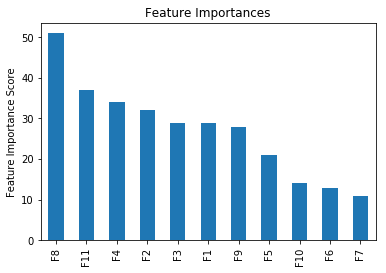

In [34]:
df_meta_features_train_v3 = pd.DataFrame(meta_features_train_v3, columns=["F{}".format(x) for x in range(1, 11 + 1)])
model_fit(XGBClassifier(**xgb_base_params), df_meta_features_train_v3, df_meta_features_train_v3.columns.values)

In [53]:
xgb_v3_md_mcw = {
    "max_depth": range(1, 4),
    "min_child_weight": range(0, 2 + 1)
}

gs_xgb_v3_md_mcw = GridSearchCV(estimator=XGBClassifier(**final_xgb_v3_params), 
                                                       param_grid=xgb_v3_md_mcw, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_md_mcw.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=56,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3], 'min_child_weight': [0, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [44]:
# Run 1
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 3, 'min_child_weight': 0}
0.77683418973155


In [54]:
# Run 2
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 3, 'min_child_weight': 0}
0.77683418973155


In [60]:
xgb_v3_gamma = {
    "gamma": [0.185, 0.186, 0.187, 0.188, 0.189, 0.19, 0.191, 0.192, 0.193, 0.194, 0.195]
}

gs_xgb_v3_gamma = GridSearchCV(estimator=XGBClassifier(**final_xgb_v3_params), 
                                                       param_grid=xgb_v3_gamma, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_gamma.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   14.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=56,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.185, 0.186, 0.187, 0.188, 0.189, 0.19, 0.191, 0.192, 0.193, 0.194, 0.195]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [56]:
# Run 1
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.2}
0.7768581661860074


In [58]:
# Run 2
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.19}
0.7768581661860074


In [61]:
# Run 3
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.19}
0.7768581661860074


In [76]:
xgb_v3_ss_cb = {
    "subsample": [0.645, 0.65, 0.655],
    "colsample_bytree": [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
}

gs_xgb_v3_ss_cb = GridSearchCV(estimator=XGBClassifier(**final_xgb_v3_params), 
                                                       param_grid=xgb_v3_ss_cb, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_ss_cb.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   27.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.19, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=0, missing=None,
       n_estimators=56, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.65),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.645, 0.65, 0.655], 'colsample_bytree': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [64]:
# Run 1
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.65, 'colsample_bytree': 0.5}
0.7779686180633612


In [80]:
# Run 2
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.65, 'colsample_bytree': 0.5}
0.7779686180633612


In [15]:
# Make fresh Stacker instance
base_learners_v3_final = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_base",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base"
]

rf_final_v3 = RandomForestClassifier(n_estimators=300, max_depth=8, max_features=2, random_state=seed)
xgb_final_v3 = XGBClassifier(**final_xgb_v3_params)

meta_learners_v3_final = [rf_final_v3, xgb_final_v3]

stacker_v3_final = Stacker(base_learners_v3_final, meta_learners_v3_final, y_train, test_ids)
train_final_v3, test_final_v3 = stacker_v3_final.get_meta_features()
stacker_v3_final.fit_meta_learners_and_predict()
stacker_v3_final_preds = stacker_v3_final.get_final_preds(mean="harmonic")

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_bag'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'extra_trees_base'...


In [18]:
print stacker_v3_final_preds
save_preds(stacker_v3_final_preds, "_".join(base_learners_v3_final))

[ 0.97485443  0.64432279  0.93284297 ...,  0.90603796  0.98225715
  0.96157074]


### ML-ensemble Predictions

#### v1

In [77]:
rf_meta_mlens_v1 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=6)

mlens_base_learners = [
    RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1),
    LogisticRegression(C=100, tol=1e-05, solver="liblinear"),
    AdaBoostClassifier(n_estimators=395, learning_rate=1.55),
    XGBClassifier(learning_rate=0.1,
                    n_estimators=345,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    scale_pos_weight=1,
                    seed=seed)
]

ensemble_v1 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v1.add(mlens_base_learners, proba=True)
ensemble_v1.add_meta(rf_meta_mlens_v1, proba=True)
mlens_v1_preds = ensemble_v1.fit(meta_features_train_v1, y_train).predict_proba(meta_features_test_v1)[:,1]

In [78]:
print mlens_v1_preds
save_preds(mlens_v1_preds, "mlens_v1")

[ 0.9640277   0.70394427  0.95102447 ...,  0.89943802  0.98440754
  0.95957553]


#### v2

In [34]:
rf_meta_mlens_v2 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=9, max_features=5)

mlens_base_learners = [
    RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1),
    LogisticRegression(C=100, tol=1e-05, solver="liblinear"),
    ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy"),
    AdaBoostClassifier(n_estimators=395, learning_rate=1.55),
    XGBClassifier(learning_rate=0.1,
                    n_estimators=345,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    scale_pos_weight=1,
                    seed=seed),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=2),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=4),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=8),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=16),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=32),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=64),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=128),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=256),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=512),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=1024)
]

ensemble_v2 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v2.add(mlens_base_learners, proba=True)
ensemble_v2.add_meta(rf_meta_mlens_v2, proba=True)
mlens_v2_preds = ensemble_v2.fit(meta_features_train_v2, y_train).predict_proba(meta_features_test_v2)[:,1]

In [35]:
print mlens_v2_preds
save_preds(mlens_v2_preds, "mlens_v2")

[ 0.97149235  0.76364833  0.96501911 ...,  0.92276353  0.98632556
  0.96678698]


After looking at the LB scores, it seems adding KNeighborsClassifier models don't improve the stacking ensemble.

#### v3

In [21]:
rf_meta_mlens_v3 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=8, max_features=2)
xgb_meta_mlens_v3 = XGBClassifier(**final_xgb_v3_params)

mlens_base_learners_v3 = [
    RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1),
    LogisticRegression(C=100, tol=1e-05, solver="liblinear"),
    ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy"),
    AdaBoostClassifier(n_estimators=395, learning_rate=1.55),
    XGBClassifier(learning_rate=0.1,
                    n_estimators=345,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    scale_pos_weight=1,
                    seed=seed),
    BaggingClassifier(base_estimator=XGBClassifier(learning_rate=0.1,
                                                    n_estimators=345,
                                                    max_depth=8,
                                                    min_child_weight=2,
                                                    gamma=0.2,
                                                    subsample=0.6,
                                                    colsample_bytree=0.5,
                                                    objective="binary:logistic",
                                                    n_jobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=seed), 
                      n_estimators=50, max_samples=0.7, max_features=0.75, bootstrap_features=True)
]

ensemble_v3 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v3.add(mlens_base_learners_v3, proba=True)
# ensemble_v3.add_meta(rf_meta_mlens_v3, proba=True)
ensemble_v3.add_meta(xgb_meta_mlens_v3, proba=True)
mlens_v3_preds = ensemble_v3.fit(meta_features_train_v3, y_train).predict_proba(meta_features_test_v3)[:,1]

/Users/julian/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


In [23]:
print mlens_v3_preds
save_preds(mlens_v3_preds, "mlens_v3_xgb_meta_only")

[ 0.98159868  0.6663233   0.94211096 ...,  0.92641664  0.98821068
  0.95964485]
